In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/Colab Notebooks")  # Change directory to your folder

# Verify it's correctly set
print("Current Working Directory:", os.getcwd())

# List files to check if scripts are accessible
print(os.listdir("."))

Mounted at /content/drive
Current Working Directory: /content/drive/My Drive/Colab Notebooks
['Untitled0.ipynb', 'LLM_Codes', 'Copy of Lab2.ipynb', '20230802_Lab_3_fine_tune_model_to_detoxify_summaries_submission.ipynb', 'Untitled', 'Untitled1.ipynb', 'HW2_Pyspark.ipynb', 'Untitled2.ipynb', 'CIFAR10_CNN.ipynb', 'CNN_CatsDogs.ipynb', 'CNN_DogsCats.ipynb', 'Untitled3.ipynb', 'Untitled4.ipynb', 'TL2.ipynb', 'PA2_Purhar.ipynb', 'PA2_submission1.ipynb', 'Chikki_Ass.ipynb', 'models', 'transformers_v2.ipynb', 'MLAssignment4.ipynb', 'Untitled5.ipynb', 'MyResume_Chatbot.ipynb', 'best_transformer_model.pth', 'transformers_full_code.ipynb']


In [ ]:

!pip install torchtext==0.16.0 --no-cache-dir
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_news_sm
!pip install sacrebleu
!pip install --upgrade --force-reinstall portalocker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 201.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 175.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 223.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 187.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 134.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 190.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 154.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 133.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 148, in _get_module_details
  File "<frozen runpy>", line 112, in _get_module_details
  File "/usr/local/lib/python3.11/dist-packages/spacy/__init__.py", line 6, in <module>
    from .errors import setup_default_warnings
  File "/usr/local/lib/python3.11/dist-packages/spacy/errors.py", line 3, in <module>
    from .compat import Literal
  File "/usr/local/lib/python3.11/dist-packages/spacy/compat.py", line 4, in <module>
    from thinc.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from torch.utils.data import DataLoader

import random
import sys
import time

import matplotlib.pyplot as plt
from torchtext.data.metrics import bleu_score

In [ ]:
print(torch.__version__)

2.1.0+cu121


In [ ]:
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn

"""
For understanding purpose lets take "Cat Loves Milk" as an input instance in the first batch of 32 samples

Let's assume:

Batch size (N) = 32
1st Sentence: "Cat Loves Milk"
Number of words (seq_len) = 24 (max_len of a sentence in the batch)
Encoder
   Input: ([<bos>,"Cat", "Loves", "Milk",<eos> , <pad>,....]) -> value_len = key_len = query_len = max_len = 24
Decoder
   Input: ([<bos>,"Katze", "liebt", "Milch", <pad>,....]) -> value_len = key_len = query_len = max_len = 23 NO <eos> ONLY <bos>
   Target: (["Katze", "liebt", "Milch", <eos>, <pad>, ...]) -> value_len = key_len = query_len = max_len = 23 NO <bos> ONLY <eos>
   i.e. a shift of token happens for decoder to predict the next word which is the target

Embedding size (embed_size) = 512
Number of heads (heads) = 8
Head dimension (head_dim) = embed_size / heads = 512 / 8 = 64
"""

class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super().__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size//heads

        assert(self.head_dim * heads == embed_size), "Embed size needs to be div by heads"

        # Each of these is a learnable weight matrix
        self.values = nn.Linear(embed_size, embed_size) # W_V (512*512 Matrix)
        self.keys = nn.Linear(embed_size, embed_size) # W_K (512*512 Matrix)
        self.queries = nn.Linear(embed_size, embed_size) # W_Q (512*512 Matrix)
        self.fc_out = nn.Linear(embed_size, embed_size) # W_O (512*512 Matrix)

    def forward(self, values, keys, query, mask):
        N = query.shape[0] # Number of Training Examples -> N = 32 in our case
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]  # 24 (23 when self attention called in Decoder) each sample length in the batch
        # Difference in Query shape and key,value shape by 1 is observed when the attention is called in Decoder AFTER masked multi head self attention i.e. at cross attention

        values = self.values(values)   # (N, value_len, embed_size) # (32, 24, 512) -> (32, 24, 512)
        keys = self.keys(keys)  # (N, key_len, embed_size)  # (32, 24, 512) -> (32, 24, 512)
        queries = self.queries(query)   # (N, query_len, embed_size)  # (32, 24 or (23 @cross atention), 512) -> (32, 24 or (23), 512)


        # Reshape into multiple heads
        values = values.reshape(N, value_len, self.heads, self.head_dim) # (32, 24, 8 , 64) nvhd
        keys = keys.reshape(N, key_len, self.heads, self.head_dim) # (32, 24, 8 , 64) nkhd
        queries = queries.reshape(N, query_len, self.heads, self.head_dim) # (32, 24, 8 , 64) nqhd


        # Einsum does matrix multiplication. for query*keys for each training example
        energy = torch.einsum("nqhd,nkhd -> nhqk", [queries, keys]) # (32, 8, 24, 24)
        # Dot product each query with each key.
        #   - We get a 24*24 (like a covariance matrix) in encoder self attention.
        #   - We get a 23*23 (like a covariance matrix) in decoder self attention.
        #   - We get a 23*24 (like a covariance matrix) in decoder cross attention.

        # This for each head. (8,24,24). On all samples in batch. (32,8,24,24)

        # Mask padded indices so their weights become close to 0   # (32, 8, 24, 24)
        if mask is not None:

            energy = energy.masked_fill(mask == 0, float("-1e20"))


        # Normalize energy values similarly to so that they sum to 1. Also divide by scaling factor for better stability
        attention = torch.softmax(energy/ (self.head_dim ** (1/2)), dim=3) # (N, heads, query_len, key_len)
        # dim = 3 indicating we operate along row across columns i.e.on query for each key

        out = torch.einsum("nhqk,nvhd->nqhd",[attention, values]) # multiplies attention scores with values. #(32, 8, 24, 24) @ (32, 24, 8, 64) → (32, 24, 8, 64)
        out = self.fc_out(out.reshape(N, query_len, self.heads * self.head_dim )) # (32, 24 (23 in decoder), 512) # Flatten the last dimensions and send it to fc_out -> # (N, query_len, embed_size)

        return out



class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super().__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion*embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion*embed_size, embed_size)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):

        """attention = self.attention(value, key, query, mask)
        x = self.dropout(self.norm1(query + attention)) # Add skip connection, run through normalization and finally dropout
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(x + forward))"""


        # Below is the Pre-LN implementation
        attention = self.attention(self.norm1(value), self.norm1(key), self.norm1(query), mask) # Apply self-attention
        x = query + self.dropout(attention)  # Skip connection with original query and dropout
        forward = self.norm2(x)  # Normalize before feedforward
        out = x + self.dropout(self.feed_forward(forward))

        return out # (32,24 (23 @ Decoder),512)


class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,  # Total vocabulary size (number of unique words)
        embed_size,      # Dimension of each word embedding # 512
        num_layers,      # Number of Transformer blocks # 6
        heads,           # Number of self-attention heads # 8
        device,          # GPU/CPU device
        forward_expansion,  # Expansion factor for the feed-forward layer
        dropout,         # Dropout rate
        max_length,      # Maximum sentence length
    ):
        super().__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size) # Converts tokenized words into dense embeddings. i.e. each word willl be represented as embedding 1D vector -> 2D vector
        self.position_embedding = nn.Embedding(max_length, embed_size) # Adds position information (since Transformers have no recurrence).

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout = dropout,
                    forward_expansion=forward_expansion
                    )
                for _ in range(num_layers)
                ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length = x.shape #(32,24) # Here x is tokenized representations of Our data # Ex: ["Cat","Loves","Milk"] -> [2(bos),7,8,9,3(eos),1(pad),1,...]. Assume N = 32 (batch), seq_length = 24 (words)
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device) #Adding positions with numbers for batch size (32,24)
        out = self.dropout(self.word_embedding(x) + self.position_embedding(positions)) # (32,24,512) + (32,24,512) Making the positions learnable by creating embeddings to them
        # word embedding ("2") returns a 512 dimensional vector
        for layer in self.layers:
            out = layer(out, out, out, mask) # value, key, query (32,24,512), mask (32,1,1,24) which are the input for forward in Transformer Encoder self attention Block
            # So masking is done only on the columns i.e. last index. Specifically on the padded indexs

        return out


class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion ):
        super().__init__()
        self.norm = nn.LayerNorm(embed_size)
        self.attention = SelfAttention(embed_size, heads) # Masked Self-Attention
        self.transformer_block = TransformerBlock(embed_size, heads, dropout = dropout, forward_expansion = forward_expansion) # Cross-Attention + Feedforward
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, x, src_mask, trg_mask):
        #print("Here at Decoder Block sending trg_mask")
        attention = self.attention(self.norm(x), self.norm(x), self.norm(x), trg_mask) # Masked Attention -> (Lower Triangular Mask + padded Tokens Mask) = trg_mask
        query = x + self.dropout(attention)
        out = self.transformer_block(value, key, query, src_mask) # Just padding Tokens Mask like Encoder Mask

        """# Post LN Implementation
        attention = self.attention(x, x, x, trg_mask) #Uses self-attention where query = key = value = x (decoder’s past words).            # Uses trg_mask → Ensures that each word only attends to past words (not future words).
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)"""
        return out


class Decoder(nn.Module):
    def __init__(
            self,
            trg_vocab_size,  # Target vocabulary size
            embed_size,      # Dimension of each word embedding # 8
            num_layers,      # Number of Transformer blocks
            heads,           # Number of self-attention heads
            device,          # GPU/CPU device
            forward_expansion,  # Expansion factor for the feed-forward layer
            dropout,         # Dropout rate
            max_length,      # Maximum sentence length
        ):
        super().__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size) # Converts tokenized words into dense embeddings.
        self.position_embedding = nn.Embedding(max_length, embed_size) # Adds position information (since Transformers have no recurrence).

        self.layers = nn.ModuleList(
            [
                DecoderBlock(
                    embed_size,
                    heads,
                    dropout = dropout,
                    forward_expansion=forward_expansion
                    )
                for _ in range(num_layers)
                ])
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(embed_size, trg_vocab_size) # Projects the decoder output into target vocabulary scores


    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape  # Here x is tokenized representations of Our data # Ex: ['Katze', 'liebt', 'Milch'] -> [2(bos),7,15,18,1(pad),1,...]. Assume N = 32 (batch), seq_length = 23 (words)
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)  #(32,23)
        x = self.dropout(self.word_embedding(x) + self.position_embedding(positions)) # (32,23,512) + (32,23,512)
        # word embedding ("2") returns a 512 dimensional vector
        for layer in self.layers:
            x = layer(enc_out, enc_out, x, src_mask, trg_mask) # value(32, 23 (24 @ Cross Attention), 512), key(32, 23 (24 @ Cross Attention), 512), query (32, 23, 512), mask (32, 1, 23, 23) which are the input for forward in Transformer Block

        out = self.fc_out(x) # (32, 23, 512) -> (32,23,trg_vocab_size) logit vectors, where each logit corresponds to the probability of a word in the target vocabulary.
        return out

class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx,
        embed_size=512,
        num_layers=6,
        forward_expansion=4,
        heads=8,
        dropout=0.0,
        device="cpu",
        max_length=100,
    ):

        super().__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)


    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # (N = src.shape[0], 1, 1, src.shape[1])

        #tensor([[[[ True,  True,  True,  ..., True,  True,  True,  True]]],   The Cat was trying to.....in the house <eos>
        #                                 .
        #                                 .
        #                                 .
        #[[[ True,  True, True, False, False, False, False]]]])         Cats Love Milk <eos> <pad>......<pad> <pad>

        return src_mask.to(self.device)


    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        # 1. Causal (Look-Ahead) Mask (lower triangular, prevents attending to future tokens)
        causal_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool() # Shape: (trg_len, trg_len) e.g., (23, 23)

        # 2. Target Padding Mask (prevents attending to <pad> tokens in the target sequence itself) This is similar to src_mask, but for the target sequence.
        padding_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2).bool()# Shape: (N, 1, 1, trg_len) e.g., (32, 1, 1, 23)

        # 3. Combine them using logical AND (position is True only if BOTH are True)
        combined_mask = causal_mask.unsqueeze(0).unsqueeze(0) & padding_mask # (32, 1, 23, 23)
        return combined_mask.to(self.device)


    def forward(self, src, trg):
        src_mask = self.make_src_mask(src) #(32,1,1,24) Booleans # To not consider any padding values
        trg_mask = self.make_trg_mask(trg) # (32,1,23,23)  Ones and Zeros # Lower Triangualr matrix to not allow peeking and not attending to padded tokens
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out


In [ ]:
# Function to yield tokens (for vocab building) sepearate for each vocabulary
def yield_tokens(data, tokenizer, lang="en"):
    for src_text, tgt_text in data:
        text = src_text if lang == "en" else tgt_text  # Choose English or German text
        yield tokenizer(text)

# converts into a tensor of numerical token IDs -> [2,21,45,.....,3]
def text_to_tensor(text, vocab, tokenizer):
    tokens = [vocab["<bos>"]] + [vocab[token] if token in vocab else vocab["<unk>"] for token in tokenizer(text)] + [vocab["<eos>"]]
    return torch.tensor(tokens, dtype=torch.long)


def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_text, tgt_text in batch:
        src_batch.append(text_to_tensor(src_text, en_vocab, en_tokenizer))
        tgt_batch.append(text_to_tensor(tgt_text, de_vocab, de_tokenizer))

    # --- REVISED PADDING ---
    # Find max length for source batch
    max_len_src = max(len(seq) for seq in src_batch)
    # Find max length for target batch
    max_len_tgt = max(len(seq) for seq in tgt_batch)

    # Pad source sequences to max_len_src
    src_batch_padded = [
        torch.cat([seq, torch.full((max_len_src - len(seq),), en_vocab["<pad>"], dtype=torch.long)])
        for seq in src_batch
    ]
    # Pad target sequences to max_len_tgt
    tgt_batch_padded = [
        torch.cat([seq, torch.full((max_len_tgt - len(seq),), de_vocab["<pad>"], dtype=torch.long)])
        for seq in tgt_batch
    ]

    src_batch_stacked = torch.stack(src_batch_padded)
    tgt_batch_stacked = torch.stack(tgt_batch_padded)

    return src_batch_stacked, tgt_batch_stacked

In [ ]:
# Tokenizers
# Tokenizer converts text into a list of tokens (words)
en_tokenizer = get_tokenizer("spacy", language = "en_core_web_sm") # Small English tokenizer model
de_tokenizer = get_tokenizer("spacy", language = "de_core_news_sm") # Small German tokenizer model

# Example:
sample_text = "This is an example sentence."
print("Tokenized sample:", en_tokenizer(sample_text))
# Expected Output: ['This', 'is', 'an', 'example', 'sentence', '.']

# Loading the data
full_train_data = list(Multi30k(split = 'train', language_pair = ('en', 'de')))[:1000] # Multi30K is a dataset for English-German translation.
# Shuffle the data to ensure randomness
random.shuffle(full_train_data)

# Split dataset into train, validation, and test (80-10-10 split)
train_size = int(0.8 * len(full_train_data))  # 80% for training
val_size = int(0.1 * len(full_train_data))    # 10% for validation
test_size = len(full_train_data) - train_size - val_size  # Remaining 10% for testing

# Create subsets
train_data = full_train_data[:train_size]
val_data = full_train_data[train_size:train_size + val_size]
test_data = full_train_data[train_size + val_size:]

print(f"Train Data: {len(train_data)} samples")
print(f"Validation Data: {len(val_data)} samples")
print(f"Test Data: {len(test_data)} samples")


print("Loaded first 2 samples:", train_data[:2])  # Print first two samples


Tokenized sample: ['This', 'is', 'an', 'example', 'sentence', '.']
Train Data: 800 samples
Validation Data: 100 samples
Test Data: 100 samples
Loaded first 2 samples: [('Three boys play with paddles on the beach.', 'Drei Jungen spielen am Strand mit Paddeln.'), ('A marketplace with rolling carts selling fruits.', 'Ein Marktplatz mit fahrbaren Wagen, wo Obst verkauft wird.')]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
num_epochs = 1
clip = 5 # Gradient Clipping to prevent exploding gradients
embed_size = 512
num_layers=6
forward_expansion=4
heads=8
dropout=0.05
device=device
max_length=256
batch_size = 128

In [ ]:
# Build vocab for the data i.e. all unique tokens(text) to Uniques IDs from the data
en_vocab = build_vocab_from_iterator(yield_tokens(train_data, en_tokenizer, lang = "en"), specials=["<unk>", "<pad>", "<bos>", "<eos>"])
de_vocab = build_vocab_from_iterator(yield_tokens(train_data, de_tokenizer, lang = "de"), specials=["<unk>", "<pad>", "<bos>", "<eos>"])

# Set unknown token index (handles words not in vocab)
en_vocab.set_default_index(en_vocab["<unk>"])
de_vocab.set_default_index(de_vocab["<unk>"])

print(f"Length of English vocab is {len(en_vocab)} and German vocab is {len(de_vocab)} for {len(train_data)} samples")

# DataLoader handles **shuffling**, **batching**, and **efficient loading**.
train_dataloader = DataLoader(train_data, batch_size = batch_size, collate_fn = collate_fn)
val_dataloader = DataLoader(val_data, batch_size = batch_size, collate_fn = collate_fn)


for src_batch, tgt_batch in train_dataloader:
    print(f"First Source batch shape : {src_batch.shape} ; First Target Batch shape : {tgt_batch.shape}")
    break


sample_german_sentence = train_data[0][1]  # Get first German sentence
print("German sentence:", sample_german_sentence)
print("Tokenized:", de_tokenizer(sample_german_sentence))
tokens = de_tokenizer("Zwei junge weiße Männer sind im Freien .")
print("Token IDs:", [de_vocab[token] for token in tokens])


Length of English vocab is 1686 and German vocab is 1928 for 800 samples
First Source batch shape : torch.Size([128, 27]) ; First Target Batch shape : torch.Size([128, 30])
German sentence: Drei Jungen spielen am Strand mit Paddeln.
Tokenized: ['Drei', 'Jungen', 'spielen', 'am', 'Strand', 'mit', 'Paddeln', '.']
Token IDs: [22, 83, 681, 36, 105, 21, 51, 4]


In [ ]:
def train(model, dataloader, optimizer, scheduler, loss_fn, device):
    model.train() # Setting the model to train mode
    epoch_loss = 0

    # dataloader = [(32,24), #English
    #                (32,24) #German]
    for batch_idx, (src,tgt) in enumerate(dataloader):
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()

        # Target input (remove last token) and target output (remove first token) # Teacher forcing strategy for seq-to-seq models
        tgt_input = tgt[:,:-1] # Input to decoder # (32,23)
        tgt_output = tgt[:,1:] # Target decoder output # (32,23)

        # Forward pass
        output = model(src, tgt_input) # (32, 23, 17000) -> (Batch_Size, Max_Target_Seq_Len - 1, Target_Vocab_Size)


        # Reshape output to match loss function expectations
        output = output.reshape(-1, output.shape[-1])  # (736, 17000)-> [batch*seq_len, vocab_size]
        tgt_output = tgt_output.reshape(-1) # (736,) -> [batch*seq_len]

        # Compute loss
        loss = loss_fn(output, tgt_output)
        loss.backward()

        # Gradient Clipping to ptevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # Update weights
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

        # # Print loss every 100 batches
        # if batch_idx % 100 == 0:
        #     print(f"Batch [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

    return epoch_loss / len(dataloader)



def evaluate(model, dataloader, loss_fn, device):
    model.eval()  # Set model to evaluation mode
    epoch_loss = 0

    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)


            tgt_input = tgt[:, :-1]  # Input to decoder (without <eos>)
            tgt_output = tgt[:, 1:]  # Target output (without <bos>)


            output = model(src, tgt_input)

            # Reshape output for loss computation
            output = output.reshape(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)

            loss = loss_fn(output, tgt_output)
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)


In [ ]:
src_pad_idx = en_vocab["<pad>"]
trg_pad_idx = de_vocab["<pad>"]
src_vocab_size = len(en_vocab)
trg_vocab_size = len(de_vocab)

# Define Transformer model
model = Transformer(
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    trg_pad_idx,
    embed_size=embed_size,
    num_layers=num_layers,
    forward_expansion=forward_expansion,
    heads=heads,
    dropout=dropout,
    device=device,
    max_length=max_length,
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=trg_pad_idx, label_smoothing=0.1)

optimizer = optim.Adam(
    model.parameters(),
    lr=0.001,            # Initial learning rate
    betas=(0.9, 0.98),   # β1 = 0.9, β2 = 0.98
    eps=1e-9             # Small epsilon value for numerical stability
)

import math

class InverseSqrtLR(optim.lr_scheduler.LambdaLR):
    def __init__(self, optimizer, d_model, warmup_steps):
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        super().__init__(optimizer, self.lr_lambda)

    def lr_lambda(self, step_num):
        step_num = max(step_num, 1)  # Ensure step_num is at least 1
        return (self.d_model ** -0.5) * min(step_num ** -0.5, step_num * (self.warmup_steps ** -1.5))

# Set up the scheduler with warm-up steps
warmup_steps = 4000
scheduler = InverseSqrtLR(optimizer, d_model=512, warmup_steps=warmup_steps)

Epoch 1: Train Loss: 221.083 | Validation Loss: 214.033 Time: 2m 38s


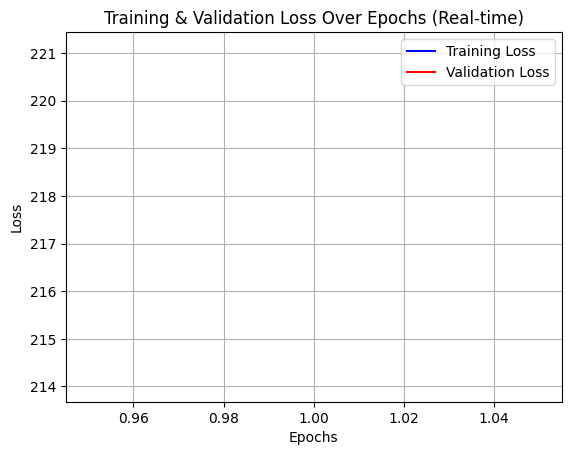

Model saved to {model_path}!


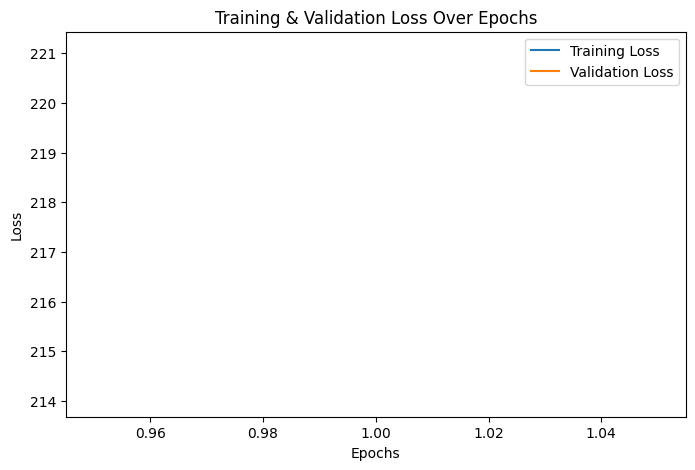

In [ ]:
# Define the directory path
import os
import datetime

model_dir = "/content/drive/My Drive/Colab Notebooks/models"
# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_filename = f"best_transformer_model_{timestamp}.pth"
model_path = os.path.join(model_dir, model_filename)


# Run training & evaluation
best_valid_loss = float("inf")
# Store loss values for visualization
train_losses = []
valid_losses = []


for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_dataloader, optimizer, scheduler, loss_fn, device)
    valid_loss = evaluate(model, val_dataloader, loss_fn, device)


    end_time = time.time()
    epoch_mins, epoch_secs = divmod(int(end_time - start_time), 60)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.3f} | Validation Loss: {valid_loss:.3f} Time: {epoch_mins}m {epoch_secs}s")

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # # Save the model if validation loss improves
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_path)
        print("Model saved to {model_path}!")

# --- End of Training ---
plt.ioff() # Turn off interactive mode
plt.show() # Keep the final plot displayed after training finishes

# Plot Training & Validation Loss After Training
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
def load_model(en_vocab, de_vocab, embed_size, num_layers, forward_expansion, heads, dropout, device, max_length, model_path):
    print("Loading model...")


    checkpoint = torch.load(model_path, map_location=device)

    model = Transformer(len(en_vocab), len(de_vocab), en_vocab["<pad>"], de_vocab["<pad>"],
                        embed_size=embed_size,
                        num_layers=num_layers,
                        forward_expansion=forward_expansion,
                        heads=heads,
                        dropout=dropout,
                        device=device,
                        max_length=max_length).to(device)

        # Get the model's current embedding weights
    model_state_dict = model.state_dict()

    # Resize encoder embedding if vocab size changed
    if checkpoint["encoder.word_embedding.weight"].shape != model_state_dict["encoder.word_embedding.weight"].shape:
        print("Resizing Encoder Embedding Layer...")
        old_embedding = checkpoint["encoder.word_embedding.weight"]
        new_embedding = model_state_dict["encoder.word_embedding.weight"]
        min_size = min(old_embedding.shape[0], new_embedding.shape[0])
        new_embedding[:min_size, :] = old_embedding[:min_size, :]
        checkpoint["encoder.word_embedding.weight"] = new_embedding

    # Resize decoder embedding if vocab size changed
    if checkpoint["decoder.word_embedding.weight"].shape != model_state_dict["decoder.word_embedding.weight"].shape:
        print("Resizing Decoder Embedding Layer...")
        old_embedding = checkpoint["decoder.word_embedding.weight"]
        new_embedding = model_state_dict["decoder.word_embedding.weight"]
        min_size = min(old_embedding.shape[0], new_embedding.shape[0])
        new_embedding[:min_size, :] = old_embedding[:min_size, :]
        checkpoint["decoder.word_embedding.weight"] = new_embedding

    # Resize output layer if vocab size changed
    if checkpoint["decoder.fc_out.weight"].shape != model_state_dict["decoder.fc_out.weight"].shape:
        print("Resizing Decoder Output Layer...")
        old_output = checkpoint["decoder.fc_out.weight"]
        new_output = model_state_dict["decoder.fc_out.weight"]
        min_size = min(old_output.shape[0], new_output.shape[0])
        new_output[:min_size, :] = old_output[:min_size, :]
        checkpoint["decoder.fc_out.weight"] = new_output

    # Resize output bias if vocab size changed
    if checkpoint["decoder.fc_out.bias"].shape != model_state_dict["decoder.fc_out.bias"].shape:
        print("Resizing Decoder Output Bias...")
        old_bias = checkpoint["decoder.fc_out.bias"]
        new_bias = model_state_dict["decoder.fc_out.bias"]
        min_size = min(old_bias.shape[0], new_bias.shape[0])
        new_bias[:min_size] = old_bias[:min_size]
        checkpoint["decoder.fc_out.bias"] = new_bias

    # Load the adjusted weights (ignore strict mismatches)
    model.load_state_dict(checkpoint, strict=False)
    model.to(device)

    return model

def translate_sentence(model, sentence, src_vocab, trg_vocab, tokenizer, device, max_length=50):
    model.eval()  # Set model to evaluation mode

    # Tokenize and convert to tensor safely
    tokens = [src_vocab["<bos>"]] + [
        src_vocab[token] if token in src_vocab else src_vocab["<unk>"] for token in tokenizer(sentence)
    ] + [src_vocab["<eos>"]]

    # Debugging: Check if any tokens are out of vocab
    for token in tokenizer(sentence):
        if token not in src_vocab:
            print(f"WARNING: Token '{token}' not in vocab. Mapping to <unk>.")

    # Convert tokens to tensor and add batch dimension
    sentence_tensor = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)

    print(f"\n Tokenized Sentence: {tokens} Sentence Tensor Shape: {sentence_tensor.shape}")
    # print(f" Max Index in Sentence: {max(tokens)}, Vocab Size: {len(src_vocab)}")

    with torch.no_grad():
        # Encode the source sentence
        src_mask = model.make_src_mask(sentence_tensor)
        enc_src = model.encoder(sentence_tensor, src_mask)

        # Initialize target sequence with <bos>
        trg_indexes = [trg_vocab["<bos>"]]

        for i in range(max_length):
            trg_tensor = torch.tensor(trg_indexes, dtype=torch.long).unsqueeze(0).to(device)
            trg_mask = model.make_trg_mask(trg_tensor)

            # Pass through the decoder
            output = model.decoder(trg_tensor, enc_src, src_mask, trg_mask)

            # Get the next token (greedy decoding)
            next_word = output.argmax(2)[:, -1].item()
            trg_indexes.append(next_word)

            # Debugging: Print top predictions
            probs = torch.softmax(output[:, -1, :], dim=-1)
            top5 = torch.topk(probs, 5)
            # print(f"Step {i+1}: Next token: {next_word} ({trg_vocab.get_itos()[next_word]}) | Top5 Predictions: {top5.indices.tolist()}")
            print(f"Generated Indexes : {trg_indexes} and shape {len(trg_indexes)}")
            # Stop if <eos> is generated
            if next_word == trg_vocab["<eos>"] or len(trg_indexes) == sentence_tensor.shape[1]:
                print(" Stopping as <eos> is generated.")
                break

    translated_tokens = [trg_vocab.get_itos()[idx] for idx in trg_indexes]
    print(f" Translated Tokens: {translated_tokens[1:-1]}")  # Excluding <bos> and <eos>
    return translated_tokens[1:-1]  # Remove <bos> and <eos>


In [ ]:
model_path = os.path.join(model_dir, "best_transformer_model.pth")
model = load_model(en_vocab, de_vocab, embed_size, num_layers, forward_expansion, heads, dropout, device, max_length, model_path)



# Example test sentence
test_sentence = "A man is playing a guitar"

translated_output = translate_sentence(model, test_sentence, en_vocab, de_vocab, en_tokenizer, device)
print("Translated Sentence:", " ".join(translated_output))


Loading model...
Resizing Encoder Embedding Layer...
Resizing Decoder Embedding Layer...
Resizing Decoder Output Layer...
Resizing Decoder Output Bias...

 Tokenized Sentence: [2, 6, 10, 11, 33, 4, 113, 3] Sentence Tensor Shape: torch.Size([1, 8])
Generated Indexes : [2, 70] and shape 2
Generated Indexes : [2, 70, 70] and shape 3
Generated Indexes : [2, 70, 70, 134] and shape 4
Generated Indexes : [2, 70, 70, 134, 134] and shape 5
Generated Indexes : [2, 70, 70, 134, 134, 134] and shape 6
Generated Indexes : [2, 70, 70, 134, 134, 134, 64] and shape 7
Generated Indexes : [2, 70, 70, 134, 134, 134, 64, 64] and shape 8
 Stopping as <eos> is generated.
 Translated Tokens: ['blauen', 'blauen', 'liegt', 'liegt', 'liegt', 'spielen']
Translated Sentence: blauen blauen liegt liegt liegt spielen


In [ ]:
def compute_bleu(model, test_data, src_vocab, trg_vocab, src_tokenizer, trg_tokenizer, device):
    model.eval()
    references = []
    hypotheses = []

    for src_sentence, trg_sentence in test_data:
        reference = [trg_tokenizer(trg_sentence)]  # Tokenize the ground-truth sentence
        hypothesis = translate_sentence(model, src_sentence, src_vocab, trg_vocab, src_tokenizer, device)

        references.append(reference)
        hypotheses.append(hypothesis)

    score = bleu_score(hypotheses, references)
    return score




# Compute BLEU Score
bleu = compute_bleu(model, test_data[:2], en_vocab, de_vocab, en_tokenizer, de_tokenizer, device)
print(f"BLEU Score: {bleu:.4f}")
